# Spark Logistic Regression with Replicated Data
This notebook reads the data splits from `04_create_data_splits` to apply a Logistic Regression model in Python and a from-scratch Logistic Regression model in Spark (with a homemade implementation of Gradient Descent).

See the `01_food_inspections_data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  See the `02_census_data_prep` notebook for the US Census API terms of use.

### Analysis and Models in this Notebook

- Simple Logistic Regression model using scikit-learn
- From-scratch Logistic Regression model using homemade implementation of Gradient Descent
- Spark MlLib Logistic Regression

### Set Global Seed

In [1]:
SEED = 666

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

from pyspark import SparkContext
from pyspark.sql.types import FloatType, StructType, StructField, LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression

import l2_regularized_logistic_regression as nplr

### Read Train and Test Splits

In [3]:
X_train = pd.read_csv('../data/X_train.gz', compression='gzip')
X_test = pd.read_csv('../data/X_test.gz', compression='gzip')
y_train = pd.read_csv('../data/y_train.gz', compression='gzip').values.flatten()
y_test = pd.read_csv('../data/y_test.gz', compression='gzip').values.flatten()

In [4]:
features = X_train.columns

### Replicate the Data to Test Model Training with More Samples

Add a bit of noise to the labels.

In [5]:
def add_binary_noise(targets):
    
    five_percent = int(0.05 * len(targets))
    idx = np.random.choice(list(range(0, len(targets))), five_percent, replace=False)
    targets[idx] = -targets[idx]
    
    return targets

In [6]:
replications = 4

In [7]:
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()
for i in range(1, replications):
    X_train = X_train.append(X_train_temp)
    X_test = X_test.append(X_test_temp)

In [8]:
y_train = add_binary_noise(nplr.transform_target(np.repeat(y_train, replications, axis=0)))
y_test = add_binary_noise(nplr.transform_target(np.repeat(y_test, replications, axis=0)))

### Scale Train and Test Sets

In [9]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train.values)
X_test_scaled = minmax_scaler.transform(X_test.values)

### Check Performance of scikit-learn Logistic Regression with No Regularization
Setting the regularization parameter to `1e8` we get effectively no regularization, as in the statsmodel API Logit model.  See this issue for details: https://github.com/scikit-learn/scikit-learn/issues/6738

In [10]:
sklearn_clf = SklearnLogisticRegression(C=1e8, # https://github.com/scikit-learn/scikit-learn/issues/6738
                                        penalty='l2',
                                        solver='liblinear',
                                        fit_intercept=True,
                                        max_iter=1000)

In [11]:
%%time
sklearn_clf.fit(X_train_scaled, np.array([0 if x == -1 else 1 for x in y_train]))

CPU times: user 2.47 s, sys: 137 ms, total: 2.61 s
Wall time: 2.61 s


LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Compute Accuracy at 0.5 Threshold

In [12]:
y_prob = sklearn_clf.predict_proba(X_test_scaled)[:, 1]

In [13]:
y_pred = [1 if x > 0.5 else 0 for x in y_prob]
np.mean(np.array([0 if x == -1 else 1 for x in y_test]) == y_pred)

0.7459550561797753

### Initialize Spark

In [14]:
sc = SparkContext.getOrCreate()
spark = (SparkSession
         .builder
         .appName("lr2")
         .config("spark.rpc.message.maxSize", "1024mb")
         .getOrCreate())

### Raw Python Version
Based on https://github.com/jstremme/l2-regularized-logistic-regression but without regularization and vectorization of matrix operations.  Instead `py_lr_grad_descent` computes the gradient on each sample sequentially, unlike Spark which will compute the gradient on each sample but in parallel.

### Logistic Regression Algorithm for Spark RDD
M. Zaharia, M. Chowdhury, T. Das, A. Dave, J. Ma,
M. McCauley, M. J. Franklin, S. Shenker, and I. Stoica. Resilient distributed datasets: A fault-tolerant
abstraction for in-memory cluster computing.
In Proceedings of NSDI, pages 15–28, 2012.

### Create new X and Ys for From-Scratch Training

In [15]:
Xt = X_train_scaled.copy()
Xt_test = X_test_scaled.copy()
yt = y_train.copy()
yt_test = y_test.copy()

### Training Functions

In [16]:
def spark_lr_grad(d):
    
    import numpy as np
    
    x = np.array(d.x)
    y = d.y
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [17]:
def spark_lr_grad_descent(w, samples, n, learning_rate, n_iter):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
        gradient = samples.map(spark_lr_grad).reduce(lambda a, b: a + b)
        w -= learning_rate * gradient * 1/n
        ws.append(w.copy())
    
    return ws

### Create a Spark Dataframe of X Vectors and y Targets
Transform the target variable to [1, -1] instead of [1, 0].

In [18]:
pd_df = pd.DataFrame(yt, columns=['y'])
pd_df['x'] = Xt.tolist()
df = spark.createDataFrame(pd_df)

### Initialize Parameters

In [19]:
samples = df.rdd
samples.cache()

MapPartitionsRDD[7] at javaToPython at NativeMethodAccessorImpl.java:0

In [20]:
# w = np.zeros(Xt.shape[1])
w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = samples.count()
learning_rate = 1.0
n_iter = 50

In [21]:
del pd_df
del df

### Run Gradient Descent

In [22]:
%%time
ws = spark_lr_grad_descent(w, samples, n, learning_rate, n_iter)

CPU times: user 350 ms, sys: 63.7 ms, total: 414 ms
Wall time: 1min 55s


### Predict

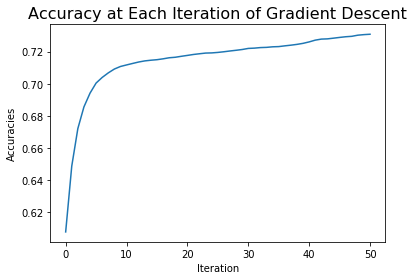

In [23]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Training Functions

In [24]:
def py_lr_grad(w, x, y):
    
    import numpy as np
    
    x = np.array(x)
    y = y.copy()
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

### Raw Python Version
Based on https://github.com/jstremme/l2-regularized-logistic-regression but without regularization and vectorization of matrix operations.  Instead `py_lr_grad_descent` computes the gradient on each sample sequentially, unlike Spark which will compute the gradient on each sample but in parallel.

In [25]:
def py_lr_grad_descent(w, X, y, n, learning_rate, n_iter, v):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
    
        gradient_total = 0
        for j in range(0, n, 1): # replaced with map and reduce in spark
            x_j = X[j]
            y_j = y[j]
            gradient_total += py_lr_grad(w, x_j, y_j)

        w -= learning_rate * gradient_total * 1/n
        ws.append(w.copy())
        
        if v:
            print('Objective function at iteration {}: {}'.format(i, nplr.obj(X, y, beta=w, lambda_penalty=0)))
    
    return ws

### Initialized_parameters

In [26]:
# w = np.zeros(Xt.shape[1])
w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = Xt.shape[0]
learning_rate = 1.0
n_iter = 50
v = 1

### Run Gradient Descent

In [27]:
%%time
ws = py_lr_grad_descent(w, Xt, yt, n, learning_rate, n_iter, v)

Objective function at iteration 0: 0.7286705046690329
Objective function at iteration 1: 0.6888096820803885
Objective function at iteration 2: 0.6698516534835821
Objective function at iteration 3: 0.6593982195732427
Objective function at iteration 4: 0.6527521373306114
Objective function at iteration 5: 0.6479699448406929
Objective function at iteration 6: 0.6441863861434808
Objective function at iteration 7: 0.6409926079704875
Objective function at iteration 8: 0.6381848020026942
Objective function at iteration 9: 0.635655495441337
Objective function at iteration 10: 0.6333441044566366
Objective function at iteration 11: 0.631213602786401
Objective function at iteration 12: 0.6292392150365818
Objective function at iteration 13: 0.6274028246957238
Objective function at iteration 14: 0.6256901587116473
Objective function at iteration 15: 0.6240893416251146
Objective function at iteration 16: 0.622590132419642
Objective function at iteration 17: 0.6211835046299539
Objective function at i

### Predict

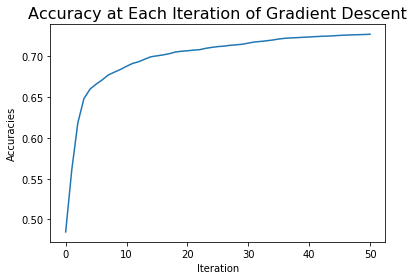

In [28]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Parallelized Numpy Version
Implementation from https://github.com/jstremme/l2-regularized-logistic-regression.  

### Run Gradient Descent

In [29]:
%%time
ws = nplr.l2_log_reg(Xt, yt, lambda_penalty=0, eps=0.001, v=0)

CPU times: user 2min 14s, sys: 1min 15s, total: 3min 29s
Wall time: 1min 50s


### Predict

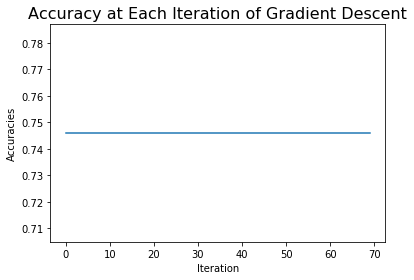

In [30]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Spark MlLib Version

In [31]:
train_df = spark.createDataFrame(nplr.to_df_with_class(X_train_scaled,
                                                       np.array([0 if x == -1 else 1 for x in y_train])))
test_df = spark.createDataFrame(nplr.to_df_with_class(X_test_scaled,
                                                      np.array([0 if x == -1 else 1 for x in y_test])))
target_column = 'class'

In [32]:
to_assemble = [item for item in train_df.columns if item != target_column]
assembler = VectorAssembler(inputCols=to_assemble, outputCol='features')
train_vector = assembler.transform(train_df)
test_vector = assembler.transform(test_df)

In [33]:
train_vector.cache().count()

533984

In [34]:
lr = SparkLogisticRegression(labelCol=target_column, featuresCol='features', regParam=0,
                             tol=0.001, standardization=False, fitIntercept=True)

In [35]:
%%time
lr = lr.fit(train_vector)

CPU times: user 26.1 ms, sys: 19.4 ms, total: 45.5 ms
Wall time: 48.8 s


In [36]:
y_pred = lr.transform(test_vector).select('prediction').rdd.map(lambda x: x.prediction).collect()
np.mean(np.array([0 if x == -1 else 1 for x in y_test]) == y_pred)

0.7459550561797753